In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from scipy.sparse import csgraph, csr_matrix


In [4]:
import json
import networkx as nx

G = nx.DiGraph()

with open("Wiki-Vote.txt") as f:
    for line in f:
        if line.startswith('#'):
            continue
        node1, node2 = map(int, line.split())
        G.add_edge(node1, node2)
        

# Quick check
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 7115
Number of edges: 103689


## Start 

In [5]:
A = nx.to_numpy_array(G)

degrees = [G.degree(n) for n in G.nodes()]
D = np.diag(degrees)

L = D-A

In [6]:
eigval, eigvectors = np.linalg.eigh(L)
e2 = eigvectors[:, 1] # get 2nd eigenvector

In [7]:
e2

array([ 9.14706475e-24, -8.39106661e-19, -1.18128465e-18, ...,
        2.79533785e-17, -1.53840375e-17,  1.60010233e-17])

In [8]:

## My way
# partitions = {0:[], 1:[]}

# for i, val in enumerate(e2):
#     if val<0:
#         partitions[0].append(i)
#     else:
#          partitions[1].append(i)


# Vectorized way - for longer lists - much more efficient (parallel)

e2 = np.array(e2)  # make sure e2 is a numpy array

# G.nodes() as a list in the same order used to make adjacency matrix
nodes = list(G.nodes())

partitions = {
    0: [nodes[i] for i in np.where(e2 < 0)[0]],
    1: [nodes[i] for i in np.where(e2 >= 0)[0]]
}
   

In [9]:

# Convert partitions dictionary to list of sets of nodes
communities = [set(nodes) for nodes in partitions.values()]

# Compute modularity
mod = nx.algorithms.community.modularity(G, communities)

print("Modularity:", mod)


Modularity: 0.03271892931694642


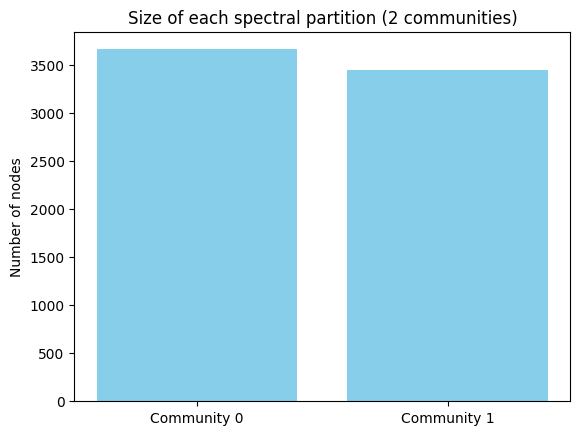

In [10]:
import matplotlib.pyplot as plt

# Get sizes of each partition
sizes = [len(nodes) for nodes in partitions.values()]

# Plot
plt.bar(range(len(sizes)), sizes, color='skyblue')
plt.xticks(range(len(sizes)), [f'Community {i}' for i in range(len(sizes))])
plt.ylabel('Number of nodes')
plt.title('Size of each spectral partition (2 communities)')
plt.show()


## KMeans

In [19]:
_vects_2_3_4 = eigvectors[:, 1:4] # get 2, 3, 4 eigenvectors - 3D - 3 n dim vectors
X = _vects_2_3_4

kmeans = KMeans(n_clusters = 3, n_init = 10, random_state = 0)
labels = kmeans.fit_predict(X)

In [20]:
import numpy as np
import networkx as nx

# Suppose labels is the output from k-means
# Convert labels to dictionary of communities
partitions = {}
for i in np.unique(labels):
    partitions[i] = np.where(labels == i)[0]  # array indices

# Map back to actual node IDs if adjacency matrix corresponds to node order
nodes = list(G.nodes())
partitions = {i: [nodes[j] for j in idx] for i, idx in partitions.items()}

# Convert to list of sets for modularity
communities = [set(nodes) for nodes in partitions.values()]

# Compute modularity
mod = nx.algorithms.community.modularity(G, communities)

print("Modularity:", mod)


Modularity: 3.857578209166502e-05


In [21]:
# Sizes of each community
sizes = [len(nodes) for nodes in partitions.values()]

# Print sizes
for i, size in enumerate(sizes):
    print(f"Community {i}: {size} nodes")


Community 0: 7111 nodes
Community 1: 2 nodes
Community 2: 2 nodes


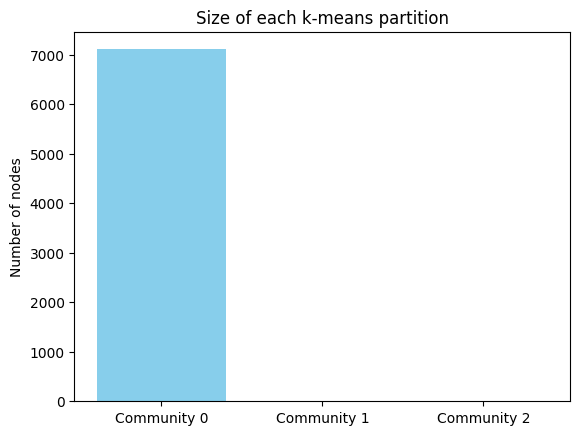

In [22]:
import matplotlib.pyplot as plt

plt.bar(range(len(sizes)), sizes, color='skyblue')
plt.xticks(range(len(sizes)), [f'Community {i}' for i in range(len(sizes))])
plt.ylabel('Number of nodes')
plt.title('Size of each k-means partition')
plt.show()


## Partitions

In [31]:
def spectral_partition(G, plot_sizes=True):
    import numpy as np
    import networkx as nx
    import matplotlib.pyplot as plt

    # Adjacency and Laplacian
    A = nx.to_numpy_array(G)
    degrees = [G.degree(n) for n in G.nodes()]
    D = np.diag(degrees)
    L = D - A

    # Eigen decomposition
    eigval, eigvectors = np.linalg.eigh(L)
    e2 = eigvectors[:, 1]  # Fiedler vector
    e2 = np.array(e2)

    nodes = list(G.nodes())
    partitions = {
        0: [nodes[i] for i in np.where(e2 < 0)[0]],
        1: [nodes[i] for i in np.where(e2 >= 0)[0]]
    }

    # Modularity
    communities = [set(nodes) for nodes in partitions.values()]
    mod = nx.algorithms.community.modularity(G, communities)

    # Plot sizes
    if plot_sizes:
        sizes = [len(nodes) for nodes in partitions.values()]
        plt.bar(range(len(sizes)), sizes, color='skyblue')
        plt.xticks(range(len(sizes)), [f'Community {i}' for i in range(len(sizes))])
        plt.ylabel('Number of nodes')
        plt.title('Size of each spectral partition (2 communities)')
        plt.show()

    return partitions, mod


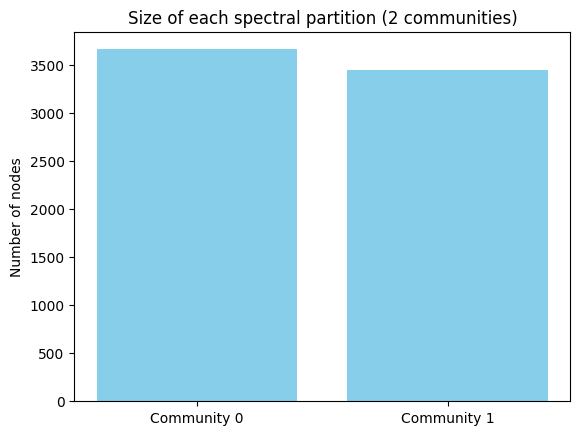

In [32]:
partitions, mod = spectral_partition(G)

In [33]:
print(mod)

0.03271892931694642


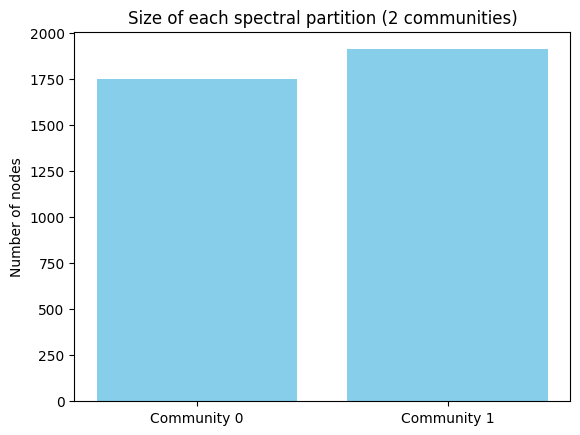

0.02893135822159698


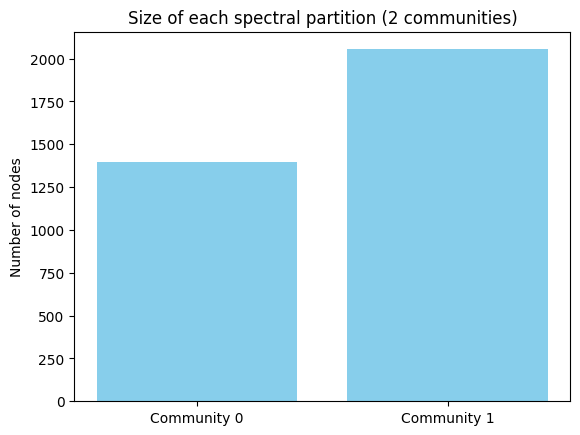

0.003842150077357692


In [42]:
part = []

for comm_nodes in partitions.values():  # iterate over node lists
    subgraph = G.subgraph(comm_nodes)   # create the subgraph
    parts, modnew = spectral_partition(subgraph)
    part.extend(parts.values())
    print(modnew)
    

In [45]:
communities = [set(comm_nodes) for comm_nodes in part]

# Calculate total modularity of the partition with respect to G
Q = nx.algorithms.community.quality.modularity(G, communities)

print("Total modularity:", Q)

Total modularity: 0.02675754754240637
